In [1]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, LeakyReLU, Input, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from nltk.corpus import stopwords
import pickle
from keras.models import load_model

## Training the discriminator

In [2]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [3]:
# Load the dataset
df = pd.read_csv('fake_and_real_news.csv')  # Assuming the dataset is in a CSV file
# The dataset should have at least two columns: 'text' and 'label'


df['Text'] = df['Text'].apply(preprocess_text)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Text'])


# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(df['Text'])




X = pad_sequences(sequences, maxlen=500)

# Labels (assuming 'label' column has 0 for fake news and 1 for real news)
df['label'] = df['label'].map({'Fake': 0, 'Real': 1})
y = df['label'].values

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the discriminator model
discriminator = Sequential()
discriminator.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
discriminator.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_news_model.keras", monitor="val_accuracy", save_best_only=True)

# Training the discriminator
discriminator.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[model_ckpt])

# Evaluate the model
loss, accuracy = discriminator.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')



Epoch 1/5


124/124 [==============================] - 240s 2s/step - loss: 0.2146 - accuracy: 0.9636 - val_loss: 0.0215 - val_accuracy: 0.9929
Epoch 2/5
124/124 [==============================] - 253s 2s/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0132 - val_accuracy: 0.9975
Epoch 3/5
124/124 [==============================] - 279s 2s/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.0221 - val_accuracy: 0.9924
Epoch 4/5
124/124 [==============================] - 298s 2s/step - loss: 4.5773e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9939
Epoch 5/5
62/62 [==============================] - 6s 91ms/step - loss: 0.0174 - accuracy: 0.9939
Validation Accuracy: 0.9939393997192383


62/62 [==============================] - 7s 107ms/step


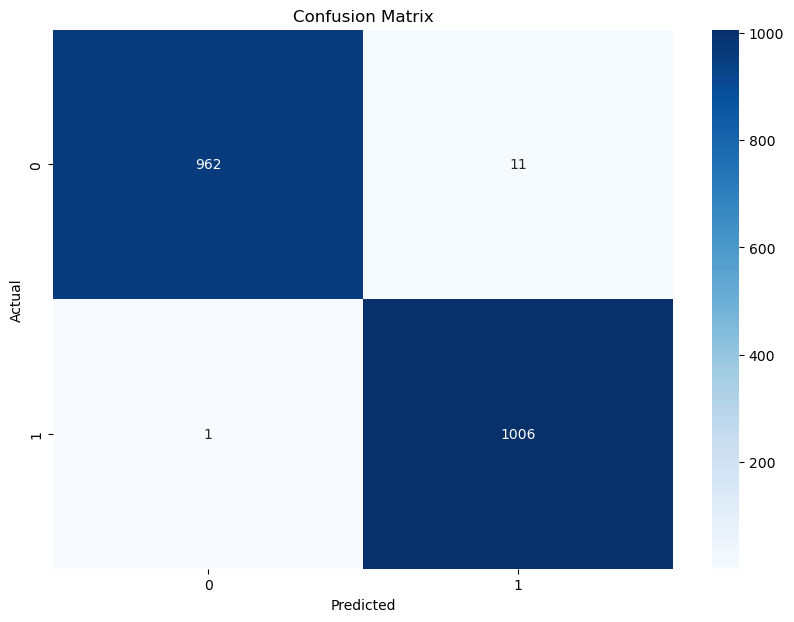

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99       973
        Real       0.99      1.00      0.99      1007

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_val_pred = discriminator.predict(X_val)
y_val_pred_classes = (y_val_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
cr = classification_report(y_val, y_val_pred_classes, target_names=['Fake', 'Real'])
print(cr)

## Classifying on the gpt2 dataset

In [4]:
# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the saved model
model = load_model('my_news_model.keras')

# Load the new dataset
gpt2_df = pd.read_csv('best_generated_texts.csv')

# Preprocess the text data
gpt2_df['Generated Text'] = gpt2_df['Generated Text'].apply(preprocess_text)

# Tokenize the new text data
new_sequences = tokenizer.texts_to_sequences(gpt2_df['Generated Text'])
X_gpt2 = pad_sequences(new_sequences, maxlen=500)

# Make predictions
predictions = model.predict(X_gpt2)

# Convert predictions to labels
gpt2_df['predicted_label'] = ['Real' if pred > 0.5 else 'Fake' for pred in predictions]

# Print the predictions
print(gpt2_df[['Generated Text', 'predicted_label']])

1/1 [==============================] - 1s 569ms/step
                                      Generated Text predicted_label
0  breaking news attack mosque uk working police ...            Fake
1  latest public speech trump said least racist p...            Fake
2  expected increase prices fruits vegetables wel...            Real
3  british museum announced opening doors public ...            Real
4  new movie openheimer released openheimer chara...            Fake
5  met gala making long time coming excited final...            Fake
6  white house news lot lately wrong reasons pres...            Real
7  exciting discovery made team researchers unive...            Fake
8  agatha kristy published new book subject calle...            Fake
